# Data Processing/Compression
The raw data for this project is around 120 GB. 

In order to more quickly process the data, I have grouped the original data by serial number and model, which should represent an individual hard drive. I then listed the first date that the hard drive appeared in the data, the last day it appeared, and then totaled the operational days for that drive.

This gave me the following columns: serial_number, model, First_Day, Last_Day, Operational_Days, and Failed.
With 'Failed' being a boolean value for whether or not the hard drive failed during the time period for the data.

Below is the code for how I transformed the data, it takes around 15-20 minutes to run.

In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta

data_directory = './raw_data/'

data_frames = []

start_date = datetime(2016, 1, 1)
end_date = start_date + timedelta(days=2738) # Jan 1st 2016 to June 30th 2023

current_date = start_date
while current_date < end_date:
    # Format the filename based on the current date
    filename = current_date.strftime('%Y-%m-%d') + '.csv'
    file_path = os.path.join(data_directory, filename)
    
    if os.path.exists(file_path):
        # There are about 130 columns in each file, but only the first 5 are useful. Others are SMART columns.
        daily_data = pd.read_csv(file_path, usecols=['model', 'failure', 'serial_number', 'date', 'capacity_bytes'])
        data_frames.append(daily_data)
    else:
        print(f'Missing Date! {filename}')
    
    # Move to the next day
    current_date += timedelta(days=1)

all_data = pd.concat(data_frames, ignore_index=True)

# Group the data by serial number and model
grouped_data = all_data.groupby(['serial_number', 'model'])

# Calculate the operational days for each drive
drive_days = grouped_data['date'].count().reset_index(name='Operational_Days')
drive_first_day = grouped_data['date'].min().reset_index(name='First_Day')
drive_last_day = grouped_data['date'].max().reset_index(name='Last_Day')

# Get the failure status for each drive, if it's failed the max should be 1.
drive_failures = grouped_data['failure'].max().reset_index(name='Failed')

drive_capacity = grouped_data['capacity_bytes'].max().reset_index(name='Capacity_bytes')

merge1 = pd.merge(drive_first_day, drive_last_day, on=['serial_number', 'model'])
merge2 = pd.merge(drive_days, drive_failures, on=['serial_number', 'model'])
merge3 = pd.merge(merge1, merge2, on=['serial_number', 'model'])

# Merge all of the data together, grouped by serial number and model (unique hard drives)
drive_stats = pd.merge(drive_capacity, merge3, on=['serial_number', 'model'])
drive_stats.to_feather('/Volumes/T7/Data Analytics Project/data.feather')

/var/folders/x1/2wgq7_fs3slcx4p6_kv5ygx40000gn/T/ipykernel_17607/3664092329.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat(data_frames, ignore_index=True)


# Data Analysis
Since our data is discrete (the hard drive either failed or it did not), using logistic regression would be the best choice.

Optimization terminated successfully.
         Current function value: 0.181876
         Iterations 7


Text(0.5, 1.0, 'Probablity of Failure as Number of Operational Days Increase')

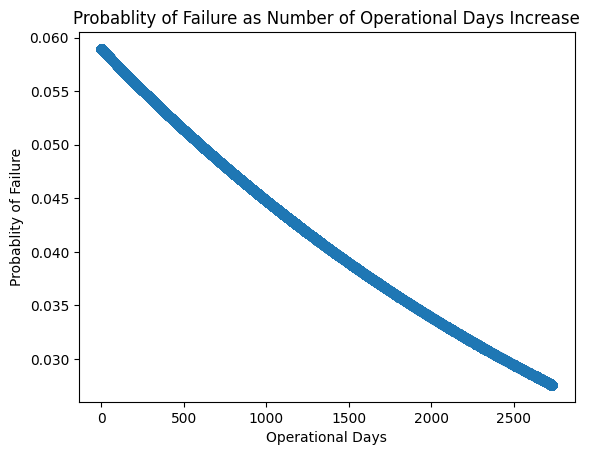

In [2]:
# Used guide: https://realpython.com/logistic-regression-python/#logistic-regression-in-python-with-statsmodels-example
# This creates our logistic model from operational days and failed.

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

file_path = './data.feather'
df = pd.read_feather(file_path)

X = df[['Operational_Days']] 
Y = df['Failed'] # Dependant variable needs to be categorical. Either failed or not failed.

# Add a constant to the independent variable
X_const = sm.add_constant(X)

# Perform logistic regression
logit_model = sm.Logit(Y, X_const)
result = logit_model.fit()

plt.scatter(X,result.predict(X_const))
plt.ylabel('Probablity of Failure')
plt.xlabel('Operational Days')
plt.title('Probablity of Failure as Number of Operational Days Increase')

In [10]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Failed   No. Observations:               350497
Model:                          Logit   Df Residuals:                   350495
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                0.004785
Time:                        11:56:33   Log-Likelihood:                -63747.
converged:                       True   LL-Null:                       -64053.
Covariance Type:            nonrobust   LLR p-value:                2.527e-135
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.7699      0.014   -197.924      0.000      -2.797      -2.743
Operational_Days    -0.0003   1.21e-05    -23.963      0.000      -0.000      -0.000
====================================================================================
"""

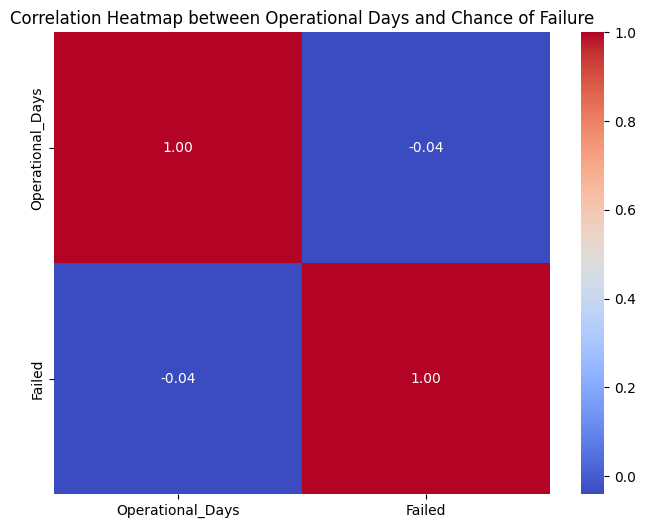

In [3]:
# Generates a correlation heat map between operational days and chance of failure.

import seaborn as sns
import matplotlib.pyplot as plt

file_path = './data.feather'
df = pd.read_feather(file_path)

relevant_data = df[['Operational_Days', 'Failed']]
correlation = relevant_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap between Operational Days and Chance of Failure")
plt.show()


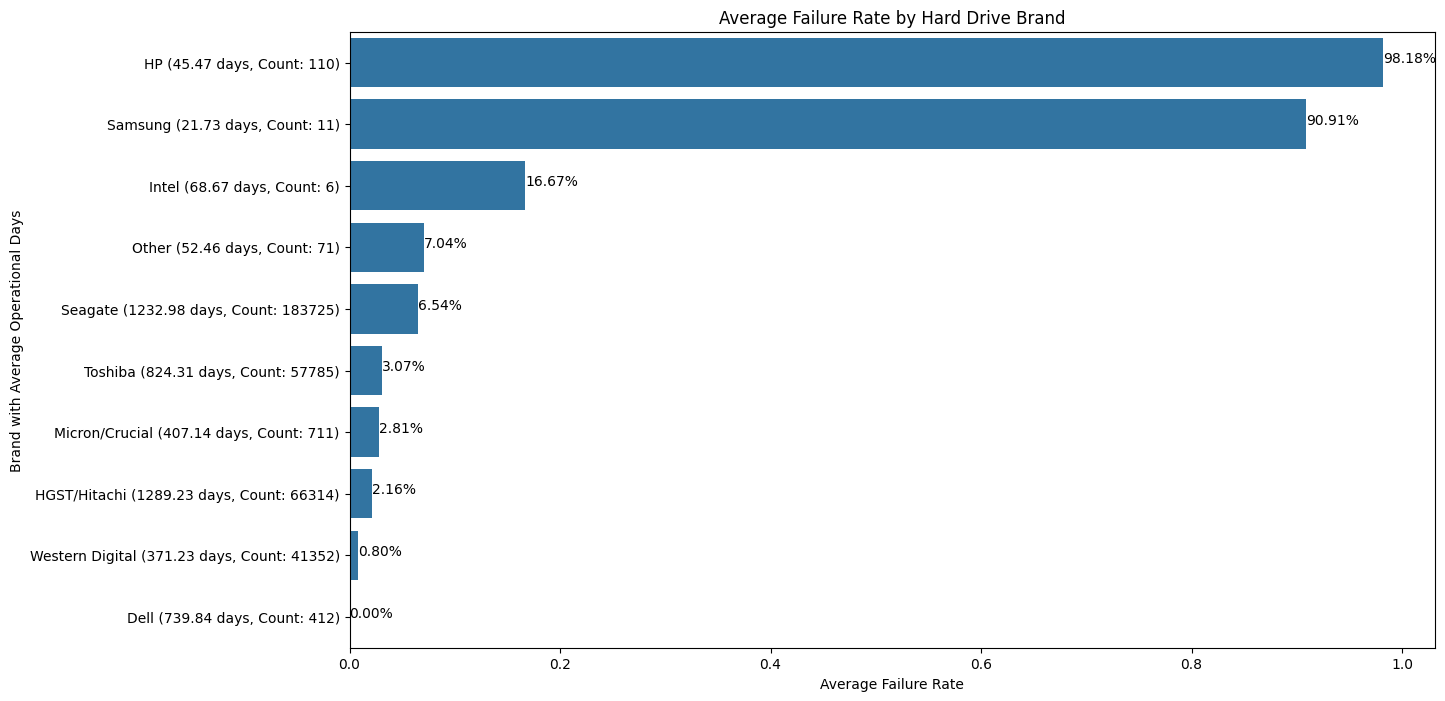

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Returns the brand name for some common models.
# Most drives contain some sort of prefix. By looking for that, we can determine the brand.
def categorize_brand(model_name):
    model_name = model_name.upper()
    if "DELL" in model_name:
        return "Dell"
    elif "TOSHIBA" in model_name:
        return "Toshiba"
    elif "HGST" in model_name or "HITACHI" in model_name:
        return "HGST/Hitachi"
    elif "WDC" in model_name:
        return "Western Digital"
    elif "ST" in model_name or "SEAGATE" in model_name:
        return "Seagate"
    elif "SAMSUNG" in model_name:
        return "Samsung"
    elif "MTFDDAV" in model_name or "CT" in model_name:
        return "Micron/Crucial"
    elif "HP" in model_name:
        return "HP"
    elif "SSDSCK" in model_name:
        return "Intel"
    else:
        return "Other"


df['Brand'] = df['model'].apply(categorize_brand)

# Grouping data by brand then computing average failure rate and average operational days for that brand
brand_comparison = df.groupby('Brand').agg(
    Average_Failure_Rate=pd.NamedAgg(column='Failed', aggfunc='mean'),
    Average_Operational_Days=pd.NamedAgg(column='Operational_Days', aggfunc='mean'),
    Hard_drive_count=pd.NamedAgg(column='model',aggfunc='count')
).reset_index().sort_values(by='Average_Failure_Rate', ascending=False)

# Adding the average operational days to the brand title, 
# as including it on the bar makes it difficult to read
brand_comparison['Brand_with_Operational_Days'] = brand_comparison.apply(
    lambda row: f"{row['Brand']} ({row['Average_Operational_Days']:.2f} days, Count: {row['Hard_drive_count']})", axis=1)


plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='Average_Failure_Rate', y='Brand_with_Operational_Days', data=brand_comparison)
plt.title('Average Failure Rate by Hard Drive Brand')
plt.xlabel('Average Failure Rate')
plt.ylabel('Brand with Average Operational Days')

# Adding the average failure rate to each bar
# Referenced: https://stackoverflow.com/a/64797097
for p in barplot.patches:
    width = p.get_width()
    # Display the width of the bar as text + some formatting
    plt.text(width, p.get_y() + p.get_height() / 2, f'{width:.2%}', color='black')

plt.show()

